# Inference of Text to Image Network

In [6]:
import torch
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from datasets import EncodedMaskedMNIST, MaskedMNIST
from cINN import ConditionalRealNVPImageTranslator
from autoencoder import AutoencoderSimple
from classifier import MultiLayerCNN
from utils import get_best_device

## Load pretrained models

In [7]:
classifier_path = "./models/classifier_multi_layer.pth"

classifier_64 = MultiLayerCNN(encode_dim=64)
classifier_64.load_state_dict(torch.load(classifier_path, map_location=get_best_device()))

classifier_128 = MultiLayerCNN(encode_dim=128)
classifier_128.load_state_dict(torch.load(classifier_path, map_location=get_best_device()))

classifier_256 = MultiLayerCNN(encode_dim=256)
classifier_256.load_state_dict(torch.load(classifier_path, map_location=get_best_device()))

<All keys matched successfully>

In [8]:
ae_path = "./models/ae_100_new.pth"
autoencoder = AutoencoderSimple()
autoencoder.load_state_dict(torch.load(ae_path, map_location=get_best_device()))

<All keys matched successfully>

In [9]:
cinn_64 = ConditionalRealNVPImageTranslator(input_size=64, hidden_size=128, n_blocks=20, condition_size=64)
cinn_64.load_state_dict(torch.load('./models/cinn_inpainting_64.pth'))

cinn_128 = ConditionalRealNVPImageTranslator(input_size=64, hidden_size=128, n_blocks=20, condition_size=128)
cinn_128.load_state_dict(torch.load('./models/cinn_inpainting_128.pth'))

cinn_256 = ConditionalRealNVPImageTranslator(input_size=64, hidden_size=128, n_blocks=20, condition_size=256)
cinn_256.load_state_dict(torch.load('./models/cinn_inpainting_256.pth'))

<All keys matched successfully>

In [10]:
test_data = MaskedMNIST(train=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

## Sample with Condition

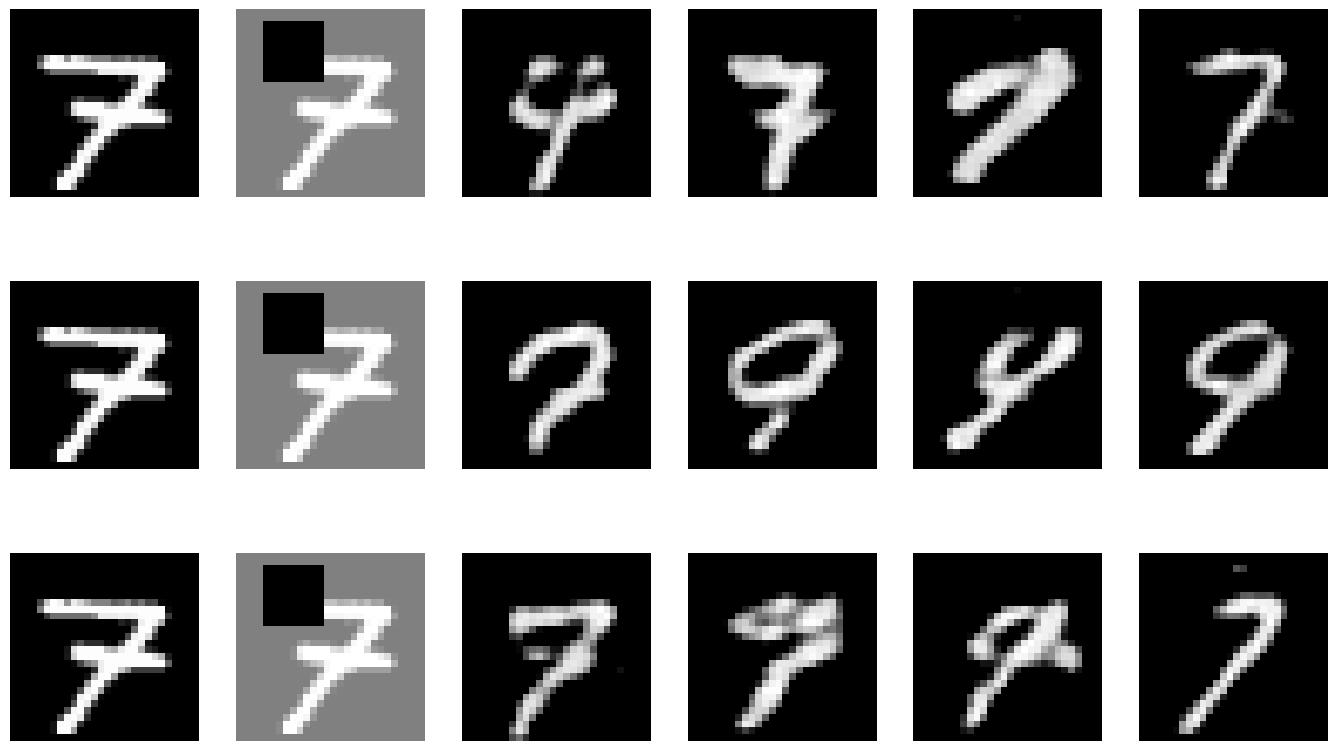

In [129]:
image, masked_image, label = test_data[64]
n_samples = 4



fig, ax = plt.subplots(3, n_samples+2, figsize=(17, 10)) # Create a figure and a set of subplots

condition = classifier_64.encode(masked_image)
cinn_64.eval()
samples = cinn_64.sample(n_samples, condition)
reconstructed_images = [autoencoder.decoder(sample).detach() for sample in samples]

# Display the original image
ax[0,0].imshow(image[0], cmap='gray')
ax[0,0].axis('off')  # Turn off axis for the first image

# Display the original image
ax[0,1].imshow(masked_image[0,:,:], cmap='gray')
ax[0,1].axis('off')  # Turn off axis for the first image

for i in range(0,n_samples):
# Display the reconstructed image
    ax[0, i+2].imshow(reconstructed_images[i][0,0,:,:], cmap='gray')
    ax[0, i+2].axis('off')  # Turn off axis for the second image

condition = classifier_128.encode(masked_image)
cinn_128.eval()
samples = cinn_128.sample(n_samples, condition)
reconstructed_images = [autoencoder.decoder(sample).detach() for sample in samples]

# Display the original image
ax[1,0].imshow(image[0], cmap='gray')
ax[1,0].axis('off')  # Turn off axis for the first image

# Display the original image
ax[1,1].imshow(masked_image[0,:,:], cmap='gray')
ax[1,1].axis('off')  # Turn off axis for the first image

for i in range(0,n_samples):
# Display the reconstructed image
    ax[1, i+2].imshow(reconstructed_images[i][0,0,:,:], cmap='gray')
    ax[1, i+2].axis('off')  # Turn off axis for the second image

condition = classifier_256.encode(masked_image)
cinn_256.eval()
samples = cinn_256.sample(n_samples, condition)
reconstructed_images = [autoencoder.decoder(sample).detach() for sample in samples]

# Display the original image
ax[2,0].imshow(image[0], cmap='gray')
ax[2,0].axis('off')  # Turn off axis for the first image

# Display the original image
ax[2,1].imshow(masked_image[0,:,:], cmap='gray')
ax[2,1].axis('off')  # Turn off axis for the first image

for i in range(0,n_samples):
# Display the reconstructed image
    ax[2, i+2].imshow(reconstructed_images[i][0,0,:,:], cmap='gray')
    ax[2, i+2].axis('off')  # Turn off axis for the second image



plt.show()

In [18]:
from torch import nn
from tqdm import tqdm
loss = nn.MSELoss()
mse = 0
correct_predictions = 0
for batch in tqdm(test_loader):
    image, masked_image, label = batch
    n_samples = 10

    condition = classifier_256.encode(masked_image)
    samples = cinn_256.sample(n_samples, condition)

    reconstructed_images = torch.stack([autoencoder.decoder(samples[i]).detach() for i in range(n_samples)])
    mean_image = torch.mean(reconstructed_images, dim=0)
    mean_image = mean_image[0]
    mse += loss(mean_image, image).item()

    output = classifier_256(mean_image)
    prediction = torch.argmax(output)
    correct_predictions += (prediction == label).sum().item()

len_data = len(test_data)
total_mse = mse/len_data
accuracy = correct_predictions/len_data * 100

print("Accuracy: ", accuracy)
print("MSE: ", total_mse)


  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\luke\anaconda3\envs\gnn\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 28, 28])) that is different to the input size (torch.Size([1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 10000/10000 [02:50<00:00, 58.51it/s]

Accuracy:  86.99
MSE:  0.03116484348096419
